In [186]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from overpresented_patterns import calculate_relative_presentation

### Parameters

In [187]:
iteration = 2
PhenoGraph_k =  200
node_label = 'CellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 50,
    'knn_k':30
}
patient_filtering_dict = {

}

# Subset 1

### Load Gram matrix and clinical data

In [188]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
Age = [clinical.loc[clinical['patient_id'] == patient_id, 'Age at Diagnosis'].values[0] for patient_id in Patient_IDs]
Grade = [clinical.loc[clinical['patient_id'] == patient_id, 'Grade'].values[0] for patient_id in Patient_IDs]
ER_status = [clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs]
PR_status = [clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs]
HER2_status = [clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs]
clinical['Clinical Subtype'] = [0 for i in range(len(clinical))]
for index, row in clinical.iterrows():
    er = row['ER Status']
    pr = row['PR Status']
    her2 = row['HER2 Status']
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        clinical.loc[index, 'Clinical Subtype'] = 1
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        clinical.loc[index, 'Clinical Subtype'] = 2
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        clinical.loc[index, 'Clinical Subtype'] = 3
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        clinical.loc[index, 'Clinical Subtype'] = 4
Clinical_subtype = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs]

Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))
print(np.percentile(Gram_matrix, 50), np.percentile(Gram_matrix, 75), np.percentile(Gram_matrix, 90), np.percentile(Gram_matrix, 95), np.percentile(Gram_matrix, 99))

379 patients are included
0.10406247701275513 0.2707331837144374 0.5019534561042462 0.6479095749207808 0.9074755432157835


### Community detection

In [189]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)

### Survival analysis for subgroups

In [190]:
if survival_type == 'Overall':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs]  
elif survival_type == 'Relapse-free':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs] 
elif survival_type == 'Disease-specific':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids = np.zeros_like(Community_ids)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids[Community_ids == HR[i]["community_id"]] = i + 1
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

379 patients are included
S1 (N = 18):
Survival: hr = 2.541615882130906, p = 0.0032383132534248406
	Significant
S2 (N = 32):
Survival: hr = 1.434335249900848, p = 0.21788787760263842
S3 (N = 96):
Survival: hr = 1.418156386096083, p = 0.0654972695146127
S4 (N = 22):
Survival: hr = 1.048564600597304, p = 0.9029636669777461
S5 (N = 80):
Survival: hr = 1.016477444944199, p = 0.9383842491405199
S6 (N = 53):
Survival: hr = 0.6377973058196351, p = 0.1384268337559997
S7 (N = 78):
Survival: hr = 0.4541634033092095, p = 0.004089447096729378
	Significant


In [191]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
for i in range(1, len(HR)+1):
    Gram_matrix_ = Gram_matrix[Subgroup_ids == i, :][:, Subgroup_ids == i]
    print("{} subgroup {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], i, caculate_mutual_similarity(Gram_matrix_)))

print("Overall {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

18 subgroup 1 patients, averaged Intra-group similarity is 0.45 
32 subgroup 2 patients, averaged Intra-group similarity is 0.54 
96 subgroup 3 patients, averaged Intra-group similarity is 0.34 
22 subgroup 4 patients, averaged Intra-group similarity is 0.71 
80 subgroup 5 patients, averaged Intra-group similarity is 0.35 
53 subgroup 6 patients, averaged Intra-group similarity is 0.66 
78 subgroup 7 patients, averaged Intra-group similarity is 0.45 
Overall 379 patients, averaged Intra-group similarity is 0.18 


### Plot hazard ratio

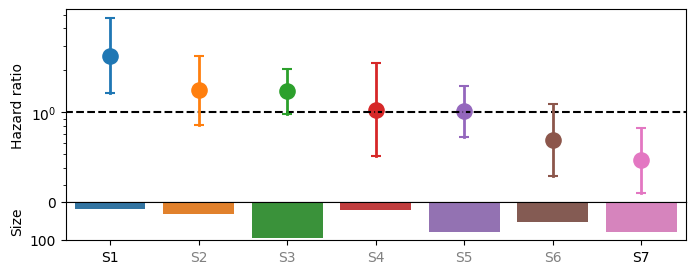

In [192]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05/len(HR):
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

### Find Over-presented Patterns

In [193]:
# Retrive cluster data
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel_random_split", "Danenberg", "Subset_1", 'Subtrees')
)
X = []
Cluster_identities = []
Indices = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    x = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            node_label,
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            node_label,
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".npy",
        )
    )
    indices = np.zeros(x.shape[0], dtype=int)
    indices[:] = i

    Indices.append(indices)
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)
Indices = np.concatenate(Indices, axis=0)
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
from definitions import get_cell_phenotype_id




In [194]:
Overpresented_patterns = {}
Candiates_overpresented_in_subgroup = []
from scipy import stats
Histograms_ = Histograms_/np.sum(Histograms_, axis=1, keepdims=True)
for hr_dict in HR:
    subgroup_id = hr_dict["subgroup_id"]
    hr = hr_dict["hr"]
    p = hr_dict["p"]
    if p <0.05/len(HR):
        Overpresented_patterns[subgroup_id] = []
        Histogram_intra_group = Histograms_[Subgroup_ids_ == subgroup_id]
        for other_subgroup_id in [i for i in range(1, len(HR)+1) if i != subgroup_id]:
            Histogram_other_group = Histograms_[Subgroup_ids_ == other_subgroup_id]
            candidates = []  
            for i in range(Histograms_.shape[1]):
                existence_intra_group = np.sum(Histogram_intra_group[:,i]>0)/Histogram_intra_group.shape[0]
                existence_out_group = np.sum(Histogram_other_group[:,i]>0)/Histogram_other_group.shape[0]
                rvsi = Histogram_intra_group[:, i]
                rvso = Histogram_other_group[:, i]
                #ratio = np.median(rvsi) / np.median(rvso)
                result = stats.mannwhitneyu(rvsi, rvso)
                if (result.pvalue < 0.05 / Histograms_.shape[1]) and (np.median(rvsi) > np.median(rvso)) :
                    candidates.append(i)
                    # print(
                    #     "Pattern {} overpresented in {} by {:.3f} times (p={:.5f}), exist in {:.0f}% patients intra group, exist {:.0f}% out of group".format(
                    #         i, subgroup_id, ratio, result.pvalue, existence_intra_group*100, existence_out_group*100
                    #     )
                    # )
            Overpresented_patterns[subgroup_id].append(set(candidates))
        Overpresented_patterns[subgroup_id] = list(set.intersection(*Overpresented_patterns[subgroup_id]))

Threshold = {}
for subgroup_id, patterns in Overpresented_patterns.items():
    threshold = []
    for pattern_id in patterns:
        histogram = Histograms_[Subgroup_ids_ == subgroup_id, pattern_id]
        threshold.append(np.percentile(histogram, 50))
    Threshold[subgroup_id] = threshold
       
print(Overpresented_patterns)
print(Threshold)

{1: [14], 7: [27, 20, 5, 31]}
{1: [0.3701156764611532], 7: [0.024912968824442314, 0.053644460528688556, 0.10175357725919523, 0.03570002098607472]}


### Plot presentation of these patterns

Subgroup 1
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S1 vs. S2: Mann-Whitney-Wilcoxon test two-sided, P_val:9.045e-07 U_stat=5.275e+02
S1 vs. S3: Mann-Whitney-Wilcoxon test two-sided, P_val:5.538e-09 U_stat=1.588e+03
S1 vs. S4: Mann-Whitney-Wilcoxon test two-sided, P_val:4.421e-07 U_stat=3.770e+02
S1 vs. S5: Mann-Whitney-Wilcoxon test two-sided, P_val:2.365e-08 U_stat=1.315e+03
S1 vs. S6: Mann-Whitney-Wilcoxon test two-sided, P_val:7.779e-09 U_stat=8.975e+02
S1 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:3.466e-08 U_stat=1.268e+03
Subgroup 7
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S6 vs. S7: Mann-Whitney-Wilcoxon test two-sided, P_val:2.567e-20 U_stat=1.560e+02
S5 vs. S7: Mann-Whit

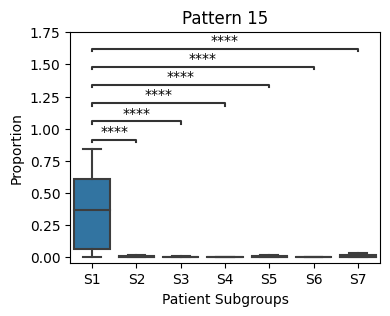

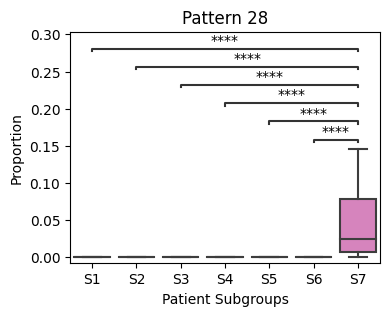

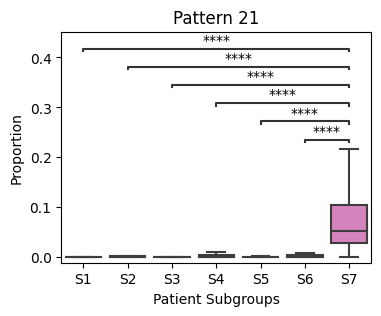

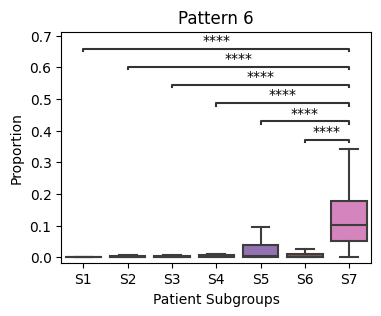

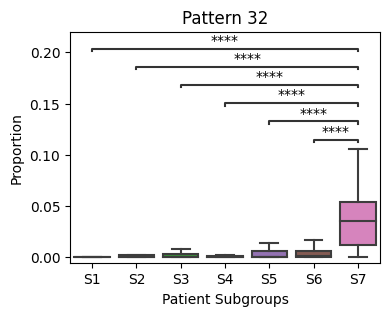

In [195]:
for subgroup_id, Candidates in Overpresented_patterns.items():
    print("Subgroup {}".format(subgroup_id))
    for pattern_id in Candidates:
        histogram = Histograms_[:, pattern_id] 
        DF_presentation = pd.DataFrame(
                {
                    "Occurence": histogram,
                    "Subgroup": ['S'+str(int(i)) for i in Subgroup_ids_],
                }
            )
        DF_presentation = DF_presentation.loc[DF_presentation["Subgroup"] != 0]
        f, ax = plt.subplots(figsize=(4, 3))
        sns.boxplot(
            x="Subgroup",
            y="Occurence",
            data=DF_presentation,
            showfliers=False,
            order=['S'+str(i) for i in range(1, len(HR)+1)],
        )
        from statannotations.Annotator import Annotator
        annot = Annotator(
            ax,
            [("S"+str(subgroup_id), "S"+str(i)) for i in range(1, len(HR)+1) if i != subgroup_id],
            data=DF_presentation,
            x="Subgroup",
            y="Occurence",
            order=['S'+str(i) for i in range(1, len(HR)+1)],
        )
        annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
        annot.apply_test()
        ax, test_results = annot.annotate()
        ax.set_title("Pattern {}".format(pattern_id+1))
        ax.set(ylabel = 'Proportion', xlabel = 'Patient Subgroups')


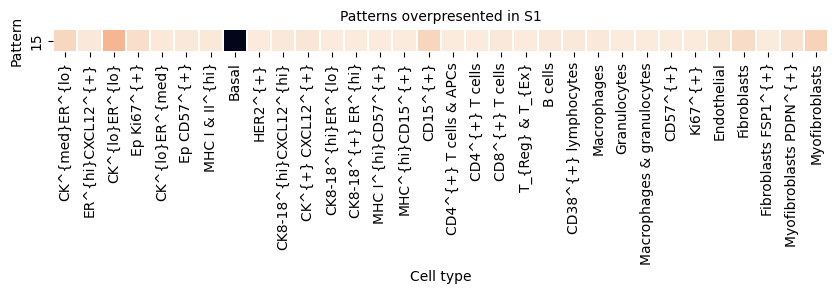

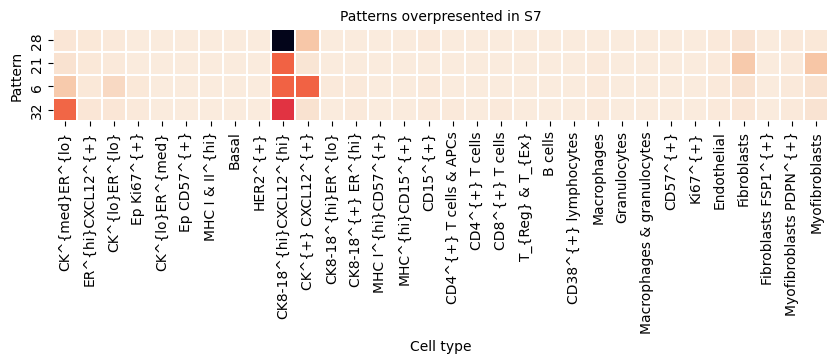

In [196]:
# Signature map before merging
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
from definitions import get_cell_phenotype_id

Centroids = compute_cluster_centroids(X, Cluster_identities)
Signature = Centroids.T
Cell_type_name_list = list(get_cell_phenotype_id('Danenberg'))

for subgroup_id, Candidates in Overpresented_patterns.items():
    f, ax= plt.subplots(1,1,figsize=(10,0.3*len(Candidates)))
    sns.heatmap(
            Signature[:, np.array(Candidates)].T,
            ax=ax,
            cbar=False,
            cmap="rocket_r",
            linewidth=0.005,
            # edgecolor="black",
            # vmax=np.percentile(Signature, 95),
            # vmin=np.percentile(Signature, 1),
        )
    ax.set_xticklabels(Cell_type_name_list, rotation=90, fontsize=10)
    ax.set_yticklabels([i+1 for i in np.array(Candidates)], fontsize=10)
    # ax.set_ylabel("TME pattern index", fontsize=10)
    ax.set(xlabel = 'Cell type', ylabel = 'Pattern')
    ax.set_title(f"Patterns overpresented in S{subgroup_id}", fontsize=10)
    plt.show()



# Fit

In [179]:
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
    "age": Age,
    "grade": Grade,
    # "clinical subtype": Clinical_subtype
})
# DF['clinical subtype'] = pd.Categorical(DF['clinical subtype'])

print(len(DF))
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    Num_patterns_to_test += len(Candidates)


# i = 0
# for subgroup_id, Candidates in Overpresented_patterns.items():
#     for pattern_id in Candidates:
#         yticklabels =['pattern ' + str(pattern_id+1)]
#         histogram = Histograms_[:, pattern_id]
#         DF["pattern_"+str(pattern_id+1)] = histogram>0
DF = DF.dropna()
cph = CoxPHFitter()
cph.fit(DF, duration_col='length', event_col='status')
cph.print_summary()

379


<lifelines.CoxPHFitter: fitted with 320 total observations, 209 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 320
number of events observed = 111
   partial log-likelihood = -571.78
         time fit was run = 2023-11-15 17:09:38 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.02       1.02       0.01             0.01             0.04                 1.01                 1.04
grade       0.92       2.50       0.18             0.56             1.27                 1.75                 3.57

            cmp to    z      p   -log2(p)
covariate                                
age           0.00 2.74   0.01       7.36
grade         0.00 5.06 <0.005      21.17
---
Concordance = 0.68
Partial AIC = 1147.57
log-likelihood ratio test = 36.52 on 2 df
-log2(p) of ll-ratio test = 26.35

# Cohort 2

In [180]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]


Age = [clinical.loc[clinical['patient_id'] == patient_id, 'Age at Diagnosis'].values[0] for patient_id in Patient_IDs_cohort2]
Grade = [clinical.loc[clinical['patient_id'] == patient_id, 'Grade'].values[0] for patient_id in Patient_IDs_cohort2]
Clinical_subtype = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_cohort2]



Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

if survival_type == 'Overall':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs_cohort2]  
elif survival_type == 'Relpase-free':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs_cohort2] 
elif survival_type == 'Disease-specific':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs_cohort2]
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]


200 patients are included


In [181]:
Histograms_cohort2_ = Histograms_cohort2_/np.sum(Histograms_cohort2_, axis=1, keepdims=True)
DF = pd.DataFrame({
    'length': Length_cohort2_,
    'status': Status_cohort2_,
    "age": Age,
    "grade": Grade,
    # "clinical subtype": Clinical_subtype
})
# DF['clinical subtype'] = pd.Categorical(DF['clinical subtype'])

# for subgroup_id, Candidates in Overpresented_patterns.items():
#     for pattern_id in Candidates:
#         yticklabels =['pattern ' + str(pattern_id+1)]
#         histogram = Histograms_cohort2_[:, pattern_id]
        
#         DF["pattern_"+str(pattern_id+1)] = histogram >0
DF = DF.dropna()
print(cph.score(DF, scoring_method='concordance_index'))

0.5877264566672107


# Jackson

In [182]:
survival_type = "Overall"
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical.rename(columns={'ERStatus': 'ER Status'}, inplace=True)
clinical.rename(columns={'HER2Status': 'HER2 Status'}, inplace=True)
clinical.rename(columns={'PRStatus': 'PR Status'}, inplace=True)
clinical['ER Status'] = clinical['ER Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['PR Status'] = clinical['PR Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['HER2 Status'] = clinical['HER2 Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
clinical['Clinical Subtype'] = [0 for i in range(len(clinical))]
for index, row in clinical.iterrows():
    er = row['ER Status']
    pr = row['PR Status']
    her2 = row['HER2 Status']
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        clinical.loc[index, 'Clinical Subtype'] = 1
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        clinical.loc[index, 'Clinical Subtype'] = 2
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        clinical.loc[index, 'Clinical Subtype'] = 3
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        clinical.loc[index, 'Clinical Subtype'] = 4
Clinical_subtype = [clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_jackson]
Age = [clinical.loc[clinical['patient_id'] == patient_id, 'age'].values[0] for patient_id in Patient_IDs_jackson]
Grade = [clinical.loc[clinical['patient_id'] == patient_id, 'grade'].values[0] for patient_id in Patient_IDs_jackson]

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]



In [185]:
Histograms_jackson = Histograms_jackson/np.sum(Histograms_jackson, axis=1, keepdims=True)
if survival_type == "Overall" or survival_type == "Disease-specific":
    Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
    Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]
elif survival_type == "Relpase-free":
    Length_jackson = [
        clinical.loc[
            clinical["patient_id"] == i, "Relapse Free Status (Months)"
        ].values[0]
        for i in Patient_IDs_jackson
    ]
    Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Relapse Free Status"].values[0]
        for i in Patient_IDs_jackson
    ]
DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]
print("{} patients are included".format(len(Patient_IDs_jackson_)))


DF = pd.DataFrame({
    'length': Length_jackson_,
    'status': Status_jackson_,
    "age": Age,
    "grade": Grade,
    # "clinical subtype": Clinical_subtype
})
# DF['clinical subtype'] = pd.Categorical(DF['clinical subtype'])

# for subgroup_id, Candidates in Overpresented_patterns.items():
#     for pattern_id in Candidates:
#         yticklabels =['pattern ' + str(pattern_id+1)]
#         histogram = Histograms_jackson_[:, pattern_id]
#         DF["pattern_"+str(pattern_id+1)] = histogram >0
cph.score(DF, scoring_method='concordance_index')

266 patients are included


0.7427520859850092

#### Presentation

0.71 0.70
0.61 0.60
0.76 0.75